<IPython.core.display.Javascript object>


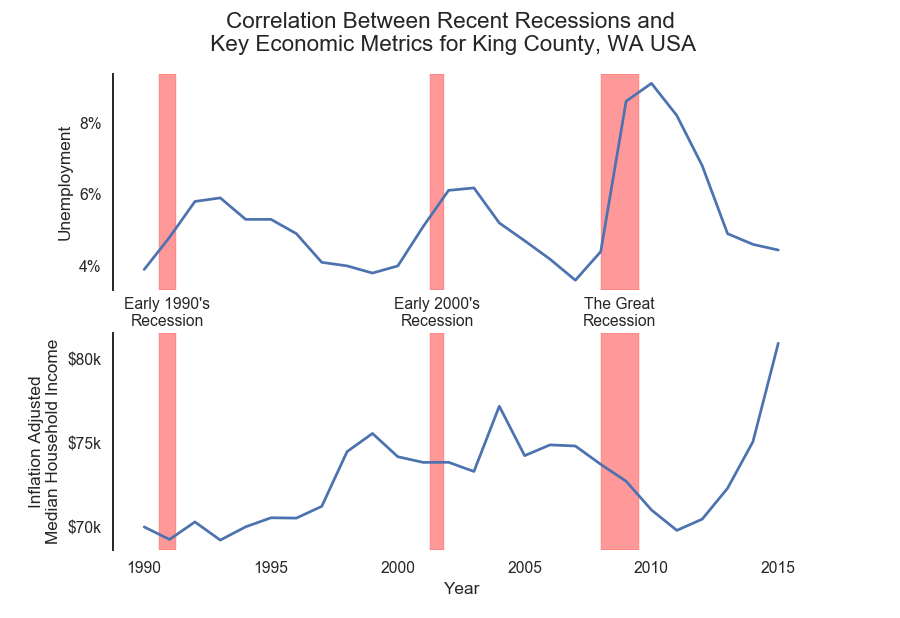

In [1]:
"""
Research Question: Is there a correlation between recent recessions and key economic metrics for King County, WA USA

Author: Duane Harkness
"""
%matplotlib notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# get consumer price index so we can adjust for inflation
# source: US Inflation Calculator
cpi = pd.read_html("http://www.usinflationcalculator.com/inflation/consumer-price-index-and-annual-percent-changes-from-1913-to-2008/",
                 index_col=0, skiprows=2)[0][[13]]
cpi.columns=["cpi-u"]
adjust = cpi.loc[1990:2015] # only interested in 1990-2015

# get median household income for King county 1990-2015
# source: Washington State Office of Financial Management
# url: http://www.ofm.wa.gov/economy/hhinc/medinc.xlsx
income = pd.read_excel("medinc.xlsx", skiprows=4, skipfooter=10)
income = income.drop(income.index[[0,1,2]])
income.rename(columns={'Unnamed: 0': 'county'}, inplace=True)
king_income = income.set_index("county").T["King"]
king_income.drop([1989, 2016], inplace=True)

# adjust for inflation - convert everything to 2015 dollars
adj_income = (king_income * adjust.loc[2015]["cpi-u"]).div(adjust["cpi-u"], axis=0)

# get unemployment rates for King county. note the spreadsheet contains one sheet per year
# source: Washington State Employment Security Department
# url: https://fortress.wa.gov/esd/employmentdata/docs/regional-reports/laus-annual-averages-not-seasonally-adjusted.xls
unemp_list = []
for i in range(1990,2016):
    this_unemp = pd.read_excel("laus-annual-averages-not-seasonally-adjusted.xls", sheetname="{:02}aa".format(i%100), header=None)
    unemp_list.append((i, this_unemp.iat[15,4]))
unemp = pd.DataFrame(unemp_list, columns=['year','rate']).set_index('year')

# combine into tidy format
econ = pd.concat([unemp,adj_income], axis=1)
econ.columns=(["Unemployment Rate", "Median Income"])

# recession start and end dates (approximate)
# source: https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States
MARCH = 3 / 12.0
JUNE = 6 / 12.0
JULY = 7 / 12.0
NOVEMBER = 10 / 12.0
DECEMBER = 12 / 12.0
recession_start = [JULY + 1990, MARCH + 2001, DECEMBER + 2007]
recession_end = [MARCH + 1991, NOVEMBER + 2001, JUNE + 2009]

# set chart style
sns.set_style("white")
style_sheet = {
    "axes.spines.bottom": False,
    "axes.spines.left": True,
    "axes.spines.top": False,
    "axes.spines.right": False
}
mpl.rcParams.update(style_sheet)

# figure layout
fig = plt.figure()
fig.suptitle("Correlation Between Recent Recessions and\n Key Economic Metrics for King County, WA USA", y=.98)
gs = mpl.gridspec.GridSpec(2,1) # grid is 2 rows by 1 columns

# unemployment plot
ax1 = plt.subplot(gs[0,0])
ax1.plot(econ["Unemployment Rate"])
for i in range(len(recession_start)):
    ax1.axvspan(recession_start[i],recession_end[i], color='red', alpha=0.4)
ax1.set_xticklabels([])
ax1.set_ylabel("Unemployment")
yformatter = mpl.ticker.FuncFormatter(lambda y, position: '{}%'.format(int(y*100)))
ax1.yaxis.set_major_formatter(yformatter) # format y axis as percentage

# median household income plot
ax2 = plt.subplot(gs[1,0])
ax2.plot(econ["Median Income"])
for i in range(len(recession_start)):
    ax2.axvspan(recession_start[i],recession_end[i], color='red', alpha=0.4)
ax2.set_xlabel("Year")
ax2.set_ylabel("Inflation Adjusted\nMedian Household Income")
yformatter = mpl.ticker.FuncFormatter(lambda y, position: '${}k'.format(int(y/1000)))
ax2.yaxis.set_major_formatter(yformatter) # format y axis as k dollars
ax2.yaxis.set_ticks([70000,75000,80000])

# annotations
trans = mpl.transforms.blended_transform_factory(ax2.transData, ax2.transAxes)
ax2.text((recession_end[0] + recession_start[0]) / 2, 1.02, "Early 1990's\nRecession",
         verticalalignment='bottom', horizontalalignment='center',
         transform=trans, fontsize=10)
ax2.text((recession_end[1] + recession_start[1]) / 2, 1.02, "Early 2000's\nRecession",
         verticalalignment='bottom', horizontalalignment='center',
         transform=trans, fontsize=10)
ax2.text((recession_end[2] + recession_start[2]) / 2, 1.02, "The Great\nRecession",
         verticalalignment='bottom', horizontalalignment='center',
         transform=trans, fontsize=10);
